In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,data.shape[3],1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

def resize_par(data, factor):
    test =  np.zeros((data.shape[0], data.shape[1],data.shape[2],data.shape[3]//factor))
    print(data.shape, test.shape)
    for i in range(6):
        test[:,i,:,:] = downscale_local_mean(data[:,i,:,:], (1,1,factor))
    return test


/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
plate = np.load('../../real_filtered.npy')[:12000]
print(plate.shape)

(12000, 6, 16, 2048)


In [3]:
%matplotlib inline
NUM_SAMPLES = 10000

print(plate.shape)
print("Creating True")
data = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=30, factor =1)
print(data.shape)
data = resize_par(data, factor=8)
data = combine(load_data_ED(data))
print(data.shape)

print("Creating False")
false_data = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=30))
false_data = resize_par(false_data, factor=8)
false_data = load_data_ED(false_data)


print("Creating True")
true_data_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =1)
true_data_1 = resize_par(true_data_1, factor=8)
true_data_1 = load_data_ED(true_data_1)

true_data_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =1)
true_data_2 = resize_par(true_data_2, factor=8)
true_data_2 = load_data_ED(true_data_2)

true_data = np.concatenate((true_data_1,true_data_2),axis=0)
print(true_data.shape)

del true_data_1,true_data_2
gc.collect()

(12000, 6, 16, 2048)
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)
(60000, 6, 16, 256)
Creating True
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(60000, 6, 16, 256, 1)


31174

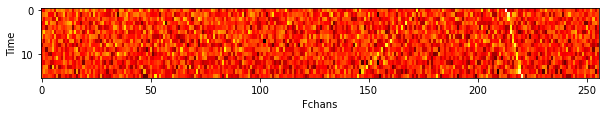

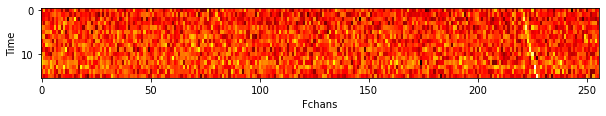

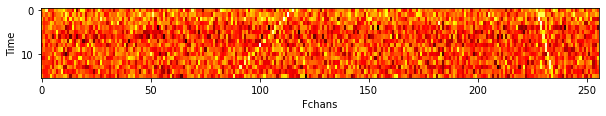

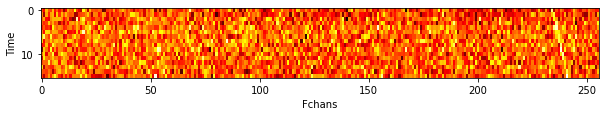

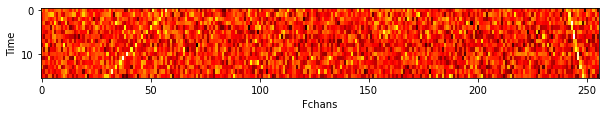

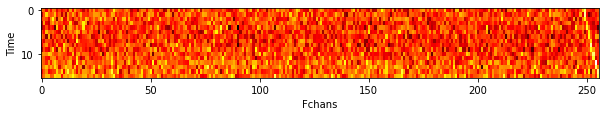

In [4]:
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[0,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

In [5]:
NUM_SAMPLES = 1000

print(plate.shape)
print("Creating True")
data_test = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=30, factor =1)
data_test = resize_par(data_test, factor=8)
data_test = combine(load_data_ED(data_test))

print("Creating False")
false_data_test = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=30))
false_data_test = resize_par(false_data_test, factor=8)
false_data_test = load_data_ED(false_data_test)


print("Creating True")
true_data_test_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =1)
true_data_test_1 = resize_par(true_data_test_1, factor=8)
true_data_test_1 = load_data_ED(true_data_test_1)

true_data_test_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =1)
true_data_test_2 = resize_par(true_data_test_2, factor=8)
true_data_test_2 = load_data_ED(true_data_test_2)


true_data_test = np.concatenate((true_data_test_1,true_data_test_2),axis=0)
print(true_data_test.shape)
del true_data_test_1,true_data_test_2
gc.collect()

(12000, 6, 16, 2048)
Creating True
(1000, 6, 16, 2048) (1000, 6, 16, 256)
(1000, 6, 16, 256)
Creating False
(6000, 6, 16, 2048) (6000, 6, 16, 256)
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)


16090

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,  **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        alpha=2
        beta=1
        self.alpha = alpha
        self.beta = beta
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(3*true_loss+false_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
        total_loss =reconstruction_loss + self.beta*kl_loss +self.alpha*(3*true_loss+false_loss)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result()
        }

In [15]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [16]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [28]:
def build_model():
    latent_dim = 8
    dens_lay = 256
    kernel = (3,12)
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dens_lay, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu")(latent_inputs)
    x = layers.Dense(1* 16 * 128, activation="relu")(x)
    x = layers.Reshape((1,16, 128))(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 8, 128, 16)   592         in

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.hdf5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

history = model.fit(x = [data,true_data,false_data ],y= data[:,:,:,:], epochs=450, batch_size=3000, 
          validation_data=([data_test,true_data_test,false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/450
20/20 [==============================] - 206s 7s/step - loss: 3005.0569 - reconstruction_loss: 2683.8062 - kl_loss: 5.3327 - false_loss: 45.7535 - true_loss: 23.0737 - val_loss: 2706.4341 - val_reconstruction_loss: 2524.7168 - val_kl_loss: 1.8966 - val_false_loss: 35.3249 - val_true_loss: 18.1952
Epoch 2/450
20/20 [==============================] - 91s 5s/step - loss: 2670.0020 - reconstruction_loss: 2495.2297 - kl_loss: 6.9632 - false_loss: 36.3362 - true_loss: 20.1671 - val_loss: 2629.7334 - val_reconstruction_loss: 2470.4849 - val_kl_loss: 3.8557 - val_false_loss: 27.5715 - val_true_loss: 16.7083
Epoch 3/450
20/20 [==============================] - 93s 5s/step - loss: 2567.0271 - reconstruction_loss: 2427.3577 - kl_loss: 7.9874 - false_loss: 28.1541 - true_loss: 18.1502 - val_loss: 2595.2722 - val_reconstruction_loss: 2445.6895 - val_kl_loss: 5.3326 - val_false_loss: 23.4709 - val_true_loss: 16.2180
Epoch 4/450
20/20 [==============================] - 92s 5s/step - loss:

20/20 [==============================] - 91s 5s/step - loss: 2504.1894 - reconstruction_loss: 2376.4417 - kl_loss: 9.8226 - false_loss: 15.1842 - true_loss: 15.6975 - val_loss: 2507.8096 - val_reconstruction_loss: 2375.6106 - val_kl_loss: 9.1606 - val_false_loss: 14.8359 - val_true_loss: 15.5611
Epoch 28/450
20/20 [==============================] - 92s 5s/step - loss: 2504.5386 - reconstruction_loss: 2375.1069 - kl_loss: 9.8878 - false_loss: 15.0945 - true_loss: 15.6798 - val_loss: 2506.8713 - val_reconstruction_loss: 2374.9031 - val_kl_loss: 9.1789 - val_false_loss: 14.7567 - val_true_loss: 15.5460
Epoch 29/450
20/20 [==============================] - 93s 5s/step - loss: 2498.8331 - reconstruction_loss: 2374.2124 - kl_loss: 9.8945 - false_loss: 14.9938 - true_loss: 15.6628 - val_loss: 2505.9697 - val_reconstruction_loss: 2374.2407 - val_kl_loss: 9.2052 - val_false_loss: 14.6605 - val_true_loss: 15.5338
Epoch 30/450
20/20 [==============================] - 89s 4s/step - loss: 2499.7851

20/20 [==============================] - 88s 4s/step - loss: 2498.3770 - reconstruction_loss: 2373.6992 - kl_loss: 10.0027 - false_loss: 13.8328 - true_loss: 15.4341 - val_loss: 2495.5095 - val_reconstruction_loss: 2366.3127 - val_kl_loss: 9.6123 - val_false_loss: 13.6748 - val_true_loss: 15.3725
Epoch 54/450
20/20 [==============================] - 90s 5s/step - loss: 2498.4687 - reconstruction_loss: 2373.5815 - kl_loss: 10.2973 - false_loss: 13.7954 - true_loss: 15.4294 - val_loss: 2495.2183 - val_reconstruction_loss: 2366.0986 - val_kl_loss: 9.6304 - val_false_loss: 13.6364 - val_true_loss: 15.3693
Epoch 55/450
20/20 [==============================] - 89s 4s/step - loss: 2495.6182 - reconstruction_loss: 2373.4778 - kl_loss: 10.4518 - false_loss: 13.7567 - true_loss: 15.4243 - val_loss: 2494.9255 - val_reconstruction_loss: 2365.8821 - val_kl_loss: 9.6453 - val_false_loss: 13.6037 - val_true_loss: 15.3651
Epoch 56/450
20/20 [==============================] - 89s 4s/step - loss: 2498.1

20/20 [==============================] - 91s 5s/step - loss: 2498.3354 - reconstruction_loss: 2373.1875 - kl_loss: 10.5978 - false_loss: 13.3578 - true_loss: 15.3471 - val_loss: 2491.3821 - val_reconstruction_loss: 2363.1140 - val_kl_loss: 9.9075 - val_false_loss: 13.1714 - val_true_loss: 15.3362
Epoch 80/450
20/20 [==============================] - 89s 4s/step - loss: 2498.9267 - reconstruction_loss: 2371.6882 - kl_loss: 10.6142 - false_loss: 13.3360 - true_loss: 15.3439 - val_loss: 2491.2104 - val_reconstruction_loss: 2362.9941 - val_kl_loss: 9.9192 - val_false_loss: 13.1460 - val_true_loss: 15.3342
Epoch 81/450
20/20 [==============================] - 89s 4s/step - loss: 2494.9148 - reconstruction_loss: 2371.8704 - kl_loss: 10.5912 - false_loss: 13.3114 - true_loss: 15.3408 - val_loss: 2491.0349 - val_reconstruction_loss: 2362.8743 - val_kl_loss: 9.9287 - val_false_loss: 13.1221 - val_true_loss: 15.3313
Epoch 82/450
20/20 [==============================] - 90s 4s/step - loss: 2493.9

20/20 [==============================] - 90s 5s/step - loss: 2492.4297 - reconstruction_loss: 2371.2258 - kl_loss: 10.2876 - false_loss: 12.9548 - true_loss: 15.2487 - val_loss: 2489.4021 - val_reconstruction_loss: 2362.0889 - val_kl_loss: 10.1171 - val_false_loss: 12.8334 - val_true_loss: 15.2549
Epoch 106/450
20/20 [==============================] - 89s 4s/step - loss: 2493.4081 - reconstruction_loss: 2371.1001 - kl_loss: 10.2424 - false_loss: 12.9355 - true_loss: 15.2466 - val_loss: 2489.2676 - val_reconstruction_loss: 2362.0020 - val_kl_loss: 10.1178 - val_false_loss: 12.8153 - val_true_loss: 15.2529
Epoch 107/450
20/20 [==============================] - 90s 5s/step - loss: 2491.3968 - reconstruction_loss: 2371.0054 - kl_loss: 10.3479 - false_loss: 12.9155 - true_loss: 15.2441 - val_loss: 2489.1218 - val_reconstruction_loss: 2361.9172 - val_kl_loss: 10.1244 - val_false_loss: 12.7933 - val_true_loss: 15.2489
Epoch 108/450
20/20 [==============================] - 93s 5s/step - loss: 

20/20 [==============================] - 89s 4s/step - loss: 2450.7986 - reconstruction_loss: 2377.1497 - kl_loss: 23.8011 - false_loss: 11.8704 - true_loss: 14.0593 - val_loss: 2481.8684 - val_reconstruction_loss: 2361.8030 - val_kl_loss: 12.1815 - val_false_loss: 11.7589 - val_true_loss: 14.0610
Epoch 132/450
20/20 [==============================] - 88s 4s/step - loss: 2446.4460 - reconstruction_loss: 2374.3657 - kl_loss: 23.8397 - false_loss: 11.8183 - true_loss: 14.0015 - val_loss: 2481.4553 - val_reconstruction_loss: 2361.7390 - val_kl_loss: 12.2795 - val_false_loss: 11.7056 - val_true_loss: 14.0042
Epoch 133/450
20/20 [==============================] - 89s 4s/step - loss: 2441.5196 - reconstruction_loss: 2373.2473 - kl_loss: 25.6624 - false_loss: 11.7637 - true_loss: 13.9417 - val_loss: 2481.1025 - val_reconstruction_loss: 2361.7480 - val_kl_loss: 12.3799 - val_false_loss: 11.6504 - val_true_loss: 13.9456
Epoch 134/450
20/20 [==============================] - 89s 4s/step - loss: 

In [24]:
model.encoder.save("VAE-ENCODER_compressed_256v4.h5")
# model.decoder.save("VAE-DECODERv14.h5")

In [ ]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
  
    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
